# Project #1

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install yfinance
!{sys.executable} -m pip install requests 
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install bootstrap-stat
!{sys.executable} -m pip install copulae

     |████████████████████████████████| 5.5MB 6.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=8048e3492825d68ba3eaa5ad1a02d26fc41f64d3ac648dd8228297cc63c021f1
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 245kB 5.6MB/s 
     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 2.0MB 4.3MB/s 
     |████████████████████████████████| 9.5MB 16.8MB/s 
     |████████████████████████████████| 27.4MB 146kB/s 
     |████████████████████████████████| 22.3MB 1.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 wh

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime 
import requests
from IPython.display import display, HTML, display_html
from bootstrap_stat import bootstrap_stat as bp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import r2_score, accuracy_score
from sklearn import tree
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')


# 1. Data Importing
## 1.1 Import 11 Select Spdrs (e.g. XLF, XLE, etc.).Some of this period did not include the Real Estate sector fund.  

We will use 'XLB' SPDR Index for our research in this work.
The Materials Select Sector Index (aka XLB) seeks to provide an effective representation of the materials sector of the S&P 500 Index. The Index includes companies from the following industries: chemicals; metals and mining; paper and forest products; containers and packaging; and construction materials.

## 1.2 Import your equity ETF prices for 2014 - 2019.

In [ ]:
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

# using XLC (Communications Sector) as 11th SPDR in addition to https://www.sectorspdr.com/sectorspdr/
# using FPX (First Trust US Equity Opportunities ETF) as US equity ETF

symbols = ['XLB', 'XLC', 'XLI', 'XLE', 'XLY', 'XLP', 
           'XLV', 'XLF', 'XLK', 'XLU', 'XLRE', 'FPX']

data = pd.DataFrame()

for sym in symbols: 
  try: 
    fund = []
    fund = yf.download(sym, start = start_date, end = end_date, progress = True)
    if (len(fund) == 0):
        None
    else:
        fund['Name'] = sym
        data = data.append(fund, sort = False)
  except Exception:
    None


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
data

# 2.1 Compute the daily returns of your Equity ETF and SPDRs

In [ ]:
df = data[['Adj Close', 'Name']].pivot(columns='Name') 
df.columns = df.columns.droplevel(0)
returns = df.pct_change().dropna()

#returns = np.log1p(df.pct_change()).dropna() 
#returns = np.log2(df).diff().dropna()

display(returns)

Name,FPX,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,,
2018-06-20,0.003925,-0.003248,0.012410,0.004416,-0.002559,0.000683,0.002100,0.000979,0.010794,0.000797,0.002121,0.004742
2018-06-21,-0.010610,-0.010635,-0.006129,-0.018517,-0.002933,-0.012555,-0.007683,0.001957,0.005967,0.003385,-0.005762,-0.007123
2018-06-22,-0.004098,0.014563,0.004376,0.019952,-0.004779,0.003455,-0.003238,0.008202,0.008742,0.006944,0.004494,-0.001704
2018-06-25,-0.018518,-0.015550,-0.020598,-0.020094,-0.010713,-0.012671,-0.020763,0.005036,-0.002476,0.016552,-0.009184,-0.021739
2018-06-26,0.001537,0.003819,0.001658,0.012629,-0.003361,0.003766,0.004038,-0.004240,0.005275,0.001163,-0.003090,0.007162
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.000372,0.002792,-0.002596,0.010267,-0.002282,0.008227,0.002859,-0.004279,-0.006015,-0.009289,0.003992,-0.002328
2019-12-24,0.001489,0.001147,-0.000186,-0.000484,0.002287,-0.004019,0.000329,0.001273,0.001316,0.001406,-0.001261,0.002253
2019-12-26,0.003593,0.004418,0.007624,-0.000323,0.005541,0.002323,0.007453,0.000954,0.006043,0.001717,-0.000680,0.012205


# 3. Data Summaries.   Extreme Values
## 3.1	Compute means.  Compute the 5% trimmed mean.  What points were considered outliers?


In [ ]:
metrics = pd.DataFrame()
metrics['mean'] = returns.mean() 
metrics['trim_mean'] = stats.trim_mean(returns, 0.05)
display(metrics)

,mean,trim_mean
Name,,
FPX,0.000304,0.000599
XLB,0.000247,0.000337
XLC,0.000287,0.000478
XLE,-0.000289,-0.000018
XLF,0.000434,0.000700
XLI,0.000417,0.000718
XLK,0.000780,0.001049
XLP,0.000683,0.000909
XLRE,0.000693,0.000936


## 3.2	Compute the inter-quartile range.  Compute the standard deviation.  How do these relate?


The interquartile range (IQR) is the difference between the 75th and 25th percentile of the data also known as a robust measure of scale. It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers. 

These robust estimator typically have inferior statistical efficiency compared to conventional estimators for data drawn from a distribution without outliers.

In [ ]:
iqr_ = []
for col in returns.columns:
  iqr_.append(stats.iqr(returns[col].dropna()))

metrics['inter-quartile range'] = iqr_
metrics['std_dev'] = returns.std() 
metrics[['inter-quartile range', 'std_dev']]

,inter-quartile range,std_dev
Name,,
FPX,0.011320,0.010758
XLB,0.013220,0.010633
XLC,0.011186,0.011813
XLE,0.014790,0.012911
XLF,0.010909,0.010525
XLI,0.010843,0.010713
XLK,0.012635,0.013135
XLP,0.008336,0.007528
XLRE,0.010369,0.008967


## 3.3	Compute the median of each series.  Compare to the mean.  Compare this difference to the skewness.


Briefly speaking, the median is the value that splits the individual data set into two halves: the (approximately) 50% largest and 50% lowest. 
While mean is average value, i.e. is equal to the sum of all the values in the data set divided by the number of values in the data set. Mean is also refrenced as "representative" or central tendency. 

The skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean:

$$ \bar \mu_3 = \frac{ \sum_i^N (X_i - \bar X)^3}{ (N-1) \sigma^3} $$


The median is called “robust against outliers“, whereas the mean actually is “sensitive to outliers“.
Another time when when it's usually prefered the median over the mean (or mode) is when the data is skewed (i.e., the frequency distribution for our data is skewed)

In [ ]:
metrics['median'] = returns.median()
metrics['skewness'] = returns.skew() 
metrics['diff_mean_and_median'] = (metrics['mean'] - metrics['median'])
metrics[['median','mean', 'diff_mean_and_median', 'skewness']]

,median,mean,diff_mean_and_median,skewness
Name,,,,
FPX,0.001194,0.000304,-0.000890,-0.296509
XLB,0.000725,0.000247,-0.000478,-0.032140
XLC,0.001085,0.000287,-0.000798,-0.164000
XLE,0.000458,-0.000289,-0.000747,-0.161747
XLF,0.001116,0.000434,-0.000682,-0.373972
XLI,0.000924,0.000417,-0.000506,-0.411650
XLK,0.001665,0.000780,-0.000884,-0.379470
XLP,0.000880,0.000683,-0.000197,-0.424363
XLRE,0.001529,0.000693,-0.000836,-0.558530



* when mean is greater than median - skewness is negative, meaning the left tail is longer
* when mean is less than median - skewness is positive, - right tail is longer
* when mean is equal to median, skewness is 0, even though 
the skewness of normal distribution is also 0, this can not be used as fact of normal distribution of data set.

## 3.4	Compute the kurtosis. Bootstrap the standard deviation.  How does the volatility of the standard deviations estimate compare to the kurtosis?

First of all, kurtosis is a measure of the "tailedness"
$$ \mu_4 = \frac{ \sum_i^N (X_i - \bar X)^4}{ (N-1) \sigma^4} $$

In other words the smaller standard deviation the bigger kurtosis i.e. higher peak. But in the real world, the standard deviation of population $\sigma$ is always unknown, so the most common measurement is to find out how accurate it can be estimated. 

The core idea of bootstrap technique is to make certain kinds of statistical inferences based on the accuracy of estimates by calculating standard error.

We will use empirical distribution function (EDF) for sampling the population and calculate kurtosis independently for each sampled index and then calculate standard error.

In [ ]:
def index_kurtosis(df):
     return stats.kurtosis(df)

se = []
# independently sample each index from data frame and calculate std error
for index in returns.columns:
  index_return = returns[index]
  index_dist = bp.EmpiricalDistribution(index_return)
  index_dist.sample(reset_index=False)
  se.append(bp.standard_error(index_dist, index_kurtosis))
 
# pandas calculates kurtosis of normal distibution as 0.0
metrics['excess_kurtosis'] = returns.kurtosis() 
metrics['std_kurtosis_error'] = se
metrics[['excess_kurtosis', 'std_kurtosis_error']]


,excess_kurtosis,std_kurtosis_error
Name,,
FPX,2.756766,0.886135
XLB,1.447250,0.540436
XLC,2.989709,0.818008
XLE,1.650201,0.884683
XLF,2.154771,0.622475
XLI,2.116711,0.623630
XLK,2.914714,0.715814
XLP,1.685463,0.466581
XLRE,1.756033,0.638819


## 3.5	What do these metrics infer about the data generation process?

In our case standard error of the estimates is quite big which could be a sign of stong depnedancy on outliers. At the same time all indexes execess kurtosis of normal distribution.

# 4. Data Inference

## 4.1	Pick 1 of the SPDRs.  Does a normal distribution fit this well?  Why or why not?


We will pick 'XLF' SPDR index.

For normality test we will use D’Agostino’s K-squared test which is based on kurtosis and skewness


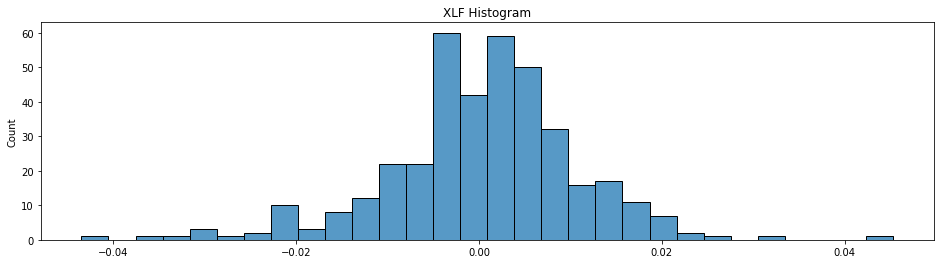

XLF kurtosis: 2.155; skewness = -0.374
XLF normal test statistic = 31.28338; pvalue = 0.00000
XLF returns not normaly distributed


In [ ]:
from scipy.stats import normaltest

selected_index1 = 'XLF'

significance_level = 0.05

def plot_hist(index_name):
  selected_return = returns[index_name]
  fig, ax = plt.subplots(1,1, figsize=(16,4))
  sns.histplot(selected_return, ax = ax)
  ax.set_title('%s Histogram' % index_name)
  ax.set_xlabel(None)
  plt.show()

def print_normaltest_result(index_name):
  selected_return = returns[index_name]
  statistic, pvalue = normaltest(selected_return) 
  print('%s kurtosis: %.3f; skewness = %.3f' % ( index_name,
           metrics.at[index_name, 'excess_kurtosis'], 
           metrics.at[index_name, 'skewness']))
  print('%s normal test statistic = %.5f; pvalue = %.5f' % ( index_name,
                                                         statistic, pvalue))
  if pvalue > significance_level:
    print('Probably, %s returns are normally distributed' % index_name)
  else:
    print('%s returns not normaly distributed' % index_name)


plot_hist(selected_index1)
print_normaltest_result(selected_index1)


Null hypothesis using skewness/kurtosis testing showed that returns for XLF are not normally distributed 

## 4.2	Pick a 2nd SPDR.  Repeat: Does a normal distribution fit this well?  Why or why not?


As second index we pick XLY - 
The Consumer Discretionary Select Sector Index includes companies from the following industries: retail (specialty, multiline, internet and direct marketing); hotels, restaurants and leisure; textiles, apparel and luxury goods; household durables; automobiles; auto components; distributors; leisure products; and diversified consumer services.

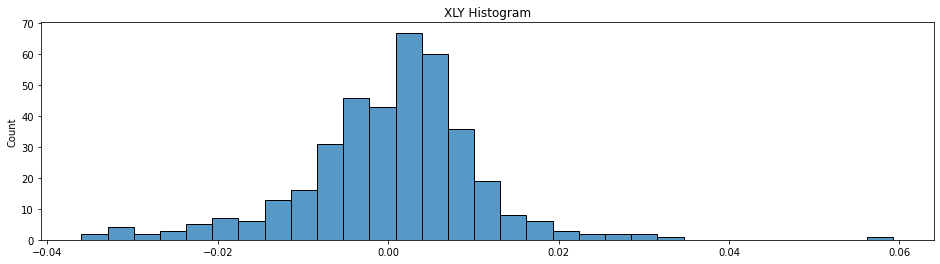

XLY kurtosis: 3.510; skewness = -0.030
XLY normal test statistic = 36.79402; pvalue = 0.00000
XLY returns not normaly distributed


In [ ]:
selected_index2 = 'XLY'
plot_hist(selected_index2)
print_normaltest_result(selected_index2)

Null hypothesis testing using skewness/kurtosis showed that returns for XLF are not normally distributed 

## 4.3	Find heavy-tailed distributions that can fit your choices from 4.1 and 4.2


The most heavy tailed index : XLB


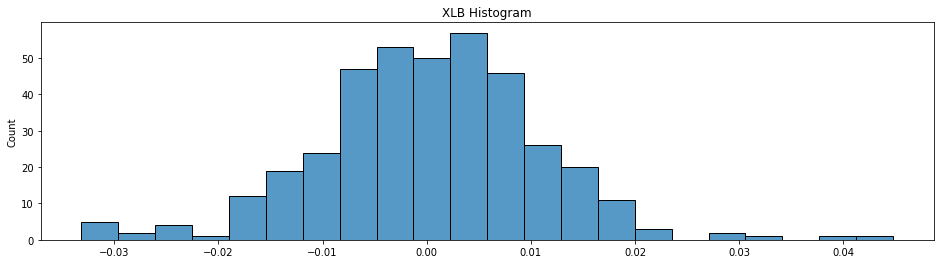

XLB kurtosis: 1.447; skewness = -0.032
XLB normal test statistic = 14.29325; pvalue = 0.00079
XLB returns not normaly distributed


In [ ]:
heavy_tail_kurtosis = metrics['excess_kurtosis'].idxmin()
print('The most heavy tailed index : %s' % heavy_tail_kurtosis )
plot_hist(heavy_tail_kurtosis)
print_normaltest_result(heavy_tail_kurtosis)

# 4.4	For each of the series you modeled, which fits better: the Gaussian distribution or the heavy-tailed distribution.  Justify your reasoning.

The closest fit to normal distribution was for XLB index with excess kurtosis (1.404 and skewness of -0.086); 
Other two index XLY ( kurtosis: 3.320; skewness = -0.115) and XLF (XLF kurtosis: 2.192; skewness = -0.437) showed worse result with normality checks

# 5. Data Comparison.  Copulas

## 5.1	Fit a Gaussian copula to the returns of those 2 SPDR series you selected in 4.1 and 4.2


**Let**'s combine selected indexes XLF, XLY

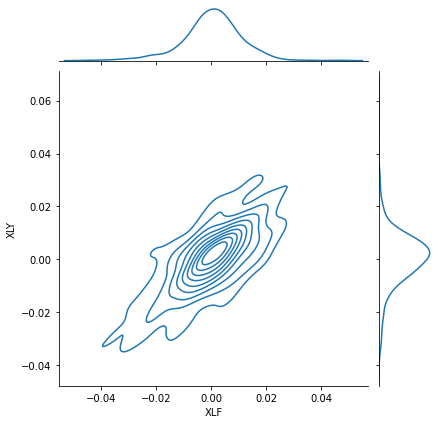

In [ ]:
# combined series of returns
combined_returns = returns[ [selected_index1, selected_index2] ]
X1 = returns[selected_index1]
X2 = returns[selected_index2]

h = sns.jointplot(X1, X2, kind='kde', stat_func=None, height=6 )
h.set_axis_labels(selected_index1, selected_index2)

Now let's sample Gaussian multivariate distribution for selected indexes

In [ ]:
from copulae import GaussianCopula

copula = GaussianCopula()
copula.fit(combined_returns)
copula.summary()

Gaussian Copula Summary
================================================================================
Gaussian Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
 1.000000  0.708717
 0.708717  1.000000



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : 130.9039006804531
Variance Estimate    : Not Implemented Yet
Method               : Maximum likelihood
Data Points          : 385

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(-1.000001, 1.000001)]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [0.70871746]
	fun            : -130.9039006804531
	jac            : [-0.06058561]
	nit            : 5
	nfev           : 12
	njev           : 5
	status         : 0
	message        : Optimization terminated successfully
	success        : True

## 5.2	Fit a non-Gaussian copula to the returns of those 2 series.  Some possibilities are Student's T, Clayton, Gumbel, choose your own, …


In [ ]:
from copulae import ClaytonCopula

copula = ClaytonCopula(dim=2)
copula.fit(combined_returns)
copula.summary()

Clayton Copula Summary
================================================================================
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 1.6248774543438957



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : 127.46613314729024
Variance Estimate    : Not Implemented Yet
Method               : Maximum likelihood
Data Points          : 385

Optimization Setup
--------------------------------------------------------------------------------
	options        : {'maxiter': 20000, 'disp': False, 'xatol': 0.0001, 'fatol': 0.0001}
	method         : Nelder-Mead

Results
--------------------------------------------------------------------------------
	fun            : -127.46613314729024
	nit            : 13
	nfev           : 26
	status         : 0
	success        : True
	message        : Optimization terminated successfully.
	x              : [1.62487745]

In [ ]:
print('Clayton copula Kendalls tau %.4f ' % copula.tau)

Clayton copula Kendalls tau 0.4483 


## 5.3	Explain how you came up with the value of the correlation for each copula.


Guassian copula is non-Archimedian copula, based on correlation matrix, which in our case is quite high 0.708. This linear correlation imposes a strong dependency on XLF and XLY returns.

Clayton copula on the other side is an asymmetric Archimedean copula, exhibiting greater dependence in the negative tail than in the positive. Kendall's tau calculated for the model is 0.4483, which represents the existence of linear correlation between returns for XLF and XLY. 

Kendall’s tau defines the rank correlations and take values in [−1, 1]:
• 0 for independent random variables.
• 1 when as X1 and X2 are comonotonic.
• −1 when X1 and X2 are countermonotonic


## 5.4	Which of the 2 copula models do you prefer?  Explain your answer in quantitative terms.

The log-likelihood can be used to compare the relative goodness-of-fit of differing models. While Clayton model has log likelihood as 127.466, the Gaussian model shows better fit results with log likelihood as 130.903.

Even though Clayton copula fits slightly worse, still, it is attractive because it characterized by a scalar parameter Theta=1.625 which can be related to a rank correlation coefficient (Spearman's rho). The
Clayton copula traces the countermonotonic, independence and comonotonic copulas as Theta moves from −1 through 0 to $\infty$. 

# 6. Category 1 Models: Lasso and PCA - Run 6 different models

## 6.1	Run a LASSO regression using your equity fund as the y variable, and up to the 4 or 5 best SPDR ETFs as potential explanatory variables.


We will use follwing 5 symbols: XLB, XLC, XLI, XLE, XLY

In [ ]:
lasso_symbols = ['XLB', 'XLC', 'XLI', 'XLE', 'XLY']
X_lasso = returns[lasso_symbols]
Y_lasso = returns[selected_index1]

Now we fit the model to LASSO and check weighted coefficients

In [ ]:
def calc_lasso(X, Y):
  lasso = Lasso(alpha=0.000015)
  lasso.fit(X, Y)
  lasso_coeff = pd.DataFrame(data=lasso.coef_, 
                          columns={'coefficients'}, 
                          index=X.columns.to_list())
  
  Y_lasso_predicted = lasso.predict(X)
  a_score = r2_score(Y, Y_lasso_predicted)*100
  print('Regression LASSO R^2 score : %.4f' % a_score )
  return lasso_coeff


lasso_coeff = calc_lasso(X_lasso, Y_lasso)

Regression LASSO R^2 score : 66.3572


In [ ]:
print("Lasso coefficients for %s" % selected_index1)
display(lasso_coeff)

Lasso coefficients for XLF


,coefficients
XLB,0.043872
XLC,0.005196
XLI,0.387707
XLE,0.103382
XLY,0.174732


## 6.2	Run a PCA regression using the CORRELATION matrix of 11 Select SPDRs.  Transform the explanatory space from 11 dimensions to a smaller number, based on the consolidation of variance explained in the first N components.


First of all we define all 11 SPDRS as explanatory space for our XLF index

In [ ]:
X = returns.drop(columns=selected_index1)
Y = returns[selected_index1]

Using the correlation matrix is equivalent to standardizing each of the variables (to mean 0 and standard deviation 1). In general, PCA with and without standardizing will give different results. Especially when the scales are different.


In [ ]:
def calc_pca_correlation(X, Y, N):
  # normalize X for std 1
  min_max_scaler = MinMaxScaler()
  X_minmax = min_max_scaler.fit_transform(X)

  pca = PCA()
  pca.fit(X_minmax)
  projection = pca.transform(X_minmax)
  projection_N = projection[:, :N]

  regr = linear_model.LinearRegression()
  regr.fit(projection_N, Y)
  r2 = regr.score(projection_N, Y) * 100
  print('Regression PCA (Correlation matrix) - R^2 score : %.4f' % r2 )
  return pca

Let's have a look if 5 variables sufficiently describe the variance of XLF:

Regression PCA (Correlation matrix) - R^2 score : 69.7487


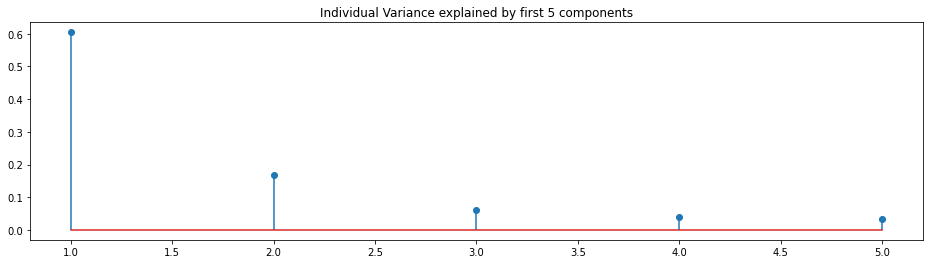

In [ ]:
pca = calc_pca_correlation(X, Y, 10)

all_variances = pca.explained_variance_ratio_
selected_variances = all_variances[:5]
selected_indexes = np.arange(1, len(selected_variances) + 1)

fig, ax = plt.subplots(figsize=(16,4))
ax.stem(selected_indexes, selected_variances, use_line_collection=True)
plt.title('Individual Variance explained by first 5 components')
plt.show()

Looks like 5 is more than sufficient

In [ ]:
N = 5
calc_pca_correlation(X, Y, N)
None

Regression PCA (Correlation matrix) - R^2 score : 68.2360


## 6.3	Run another PCA regression using the COVARIANCE matrix of 11 Select SPDRs.  Transform the explanatory space from 11 dimensions to a smaller number, based on the consolidation of variance explained in the first N components.


By default PCA works on covariance matrix, ie. we can leave our data unscaled

In [ ]:
def calc_pca_covaraince(X, Y, N):
  pca = PCA()
  pca.fit(X)
  projection = pca.transform(X)
  projection_N = projection[:, :N]

  regr = linear_model.LinearRegression()
  regr.fit(projection_N, Y)
  r2 = regr.score(projection_N, Y) * 100
  print('Regression PCA (Covariance matrix) - R^2 score : %.4f' % r2 )

calc_pca_covaraince(X, Y, N)

Regression PCA (Covariance matrix) - R^2 score : 68.0638


## 6.4	Repeat 6.1, 6.2 and 6.3 without using the extreme 5% values of the data.


Let's remove outliers by filtering distribution with Z-score, where -1.96 < x < 1.96 covers 95% 

In [ ]:
# remove all the row with outliers of 95%
z_threshold = 1.96

# removes for all columns
#returns_adj = returns[(np.abs(stats.zscore(returns)) <= z_threshold).all(axis=1)]
returns_adj = returns[(np.abs(stats.zscore(returns[selected_index1])) \
                         <= z_threshold)]

idx = returns.index.difference(returns_adj.index)
print("Following dates have been excluded: \n%s" % idx)

Following dates have been excluded: 
DatetimeIndex(['2018-07-09', '2018-10-10', '2018-10-11', '2018-10-22',
               '2018-10-24', '2018-11-20', '2018-12-04', '2018-12-24',
               '2018-12-26', '2019-01-03', '2019-01-04', '2019-01-16',
               '2019-02-15', '2019-03-20', '2019-03-22', '2019-04-01',
               '2019-05-13', '2019-06-04', '2019-08-01', '2019-08-05',
               '2019-08-14', '2019-08-23', '2019-10-01', '2019-10-02'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [ ]:
X_adj = returns_adj.drop(columns=selected_index1)
Y_adj = returns_adj[selected_index1]

X_adj_lasso = returns_adj[lasso_symbols]
Y_adj_lasso = returns_adj[selected_index1]

print("Lasso, PCA (corr) & PCA(cov) after removing ourliers")
calc_lasso(X_adj_lasso, Y_adj_lasso)
calc_pca_correlation(X_adj, Y_adj, N)
calc_pca_covaraince(X_adj, Y_adj, N)

Lasso, PCA (corr) & PCA(cov) after removing ourliers
Regression LASSO R^2 score : 47.7511
Regression PCA (Correlation matrix) - R^2 score : 54.9041
Regression PCA (Covariance matrix) - R^2 score : 53.6982


## 6.5	What are the differences when you exclude the 5%?


Ideally removing outliers should give better fit for our model, but we received worse values for $R^2$; 

This can be explained as:
*   Insufficient data collected for finding linear correlation, and removing outliers reduced the dataset even more.
*   There is no linear correlation for the model based on selected predictors, and greater value for $R^2$ on first run is simply a coincidence



## 6.6	What are the key differences in the methods between LASSO and PCA?


PCA is used for dimension reduction based on co-variance matrices, it allows to tell how many predictor are required to build linear regression model, but not the weigths of predictors. 

While Lasso provides feature selection based on coefficients of predictors and trained data set.



## 6.7	Compare the results of the models.

The best results to fit the model XLF returns have been obtained by **PCA (with correlation matrix)** model with $R^2 = 69.7487$

When predictors are highly correlated PCA is better choice, thus the method aims to minimize the variance in the predictor space by using linear combinations of the predictors. But the method does not tell which of the predictor to pick - which one is important.

On the other hand Lasso regression tries to find best fit using weights of predictors and penalty function, trying fit the model with the minimal error. Setting proper hyper-parameter $\lambda$ (penalizing) function, gives better estimates and projection when model deals with test data.

To underline : Pick Lasso Regression - when the task is to find concrete predictors and weights based on training data; And use PCA for dimension reduction for further analyzes of correlations. 



#7. Category 2 Models: Trees and SVM - Run 4 different models

Let's prepare our data for selected index XLF

In [ ]:
df_adj = df.dropna(how='any')
X = df_adj.drop(columns=selected_index1)
Y = df_adj[selected_index1]

X_train, X_test, y_train, y_test = \
  train_test_split(X, Y, test_size=0.33, random_state=123)

## 7.1	Run a regression tree using your equity fund as the y variable, and all SPDR ETFs as potential explanatory variables.


In [ ]:
def calc_regression_tree(X_train, X_test, y_train, y_test):
  clf1 = tree.DecisionTreeRegressor(random_state=0, splitter='best')
  clf1 = clf1.fit(X_train, y_train)
  y_pred = clf1.predict(X_test)
  print(f'Regression tree score = {clf1.score(X_test, y_test)}')

calc_regression_tree(X_train, X_test, y_train, y_test)

Regression tree score = 0.9374595059397494


Regression tree with weights, to demonstrate that while some insight can be gained from it, it is rather unwieldy and generally not too useful for the explanatory purpose:

In [ ]:
print('Regresstion tree with weights:')
clf1 = tree.DecisionTreeRegressor(random_state=0, splitter='best')
clf1 = clf1.fit(X_train, y_train)
textual_view = tree.export_text(clf1)
print(textual_view)


Regresstion tree with weights:
|--- feature_4 <= 74.47
|   |--- feature_1 <= 51.40
|   |   |--- feature_4 <= 65.59
|   |   |   |--- feature_5 <= 62.11
|   |   |   |   |--- feature_4 <= 64.77
|   |   |   |   |   |--- feature_8 <= 49.38
|   |   |   |   |   |   |--- value: [23.33]
|   |   |   |   |   |--- feature_8 >  49.38
|   |   |   |   |   |   |--- feature_8 <= 49.53
|   |   |   |   |   |   |   |--- value: [23.17]
|   |   |   |   |   |   |--- feature_8 >  49.53
|   |   |   |   |   |   |   |--- value: [23.22]
|   |   |   |   |--- feature_4 >  64.77
|   |   |   |   |   |--- feature_10 <= 101.73
|   |   |   |   |   |   |--- value: [23.56]
|   |   |   |   |   |--- feature_10 >  101.73
|   |   |   |   |   |   |--- value: [23.40]
|   |   |   |--- feature_5 >  62.11
|   |   |   |   |--- feature_6 <= 51.51
|   |   |   |   |   |--- feature_9 <= 84.87
|   |   |   |   |   |   |--- feature_10 <= 100.86
|   |   |   |   |   |   |   |--- value: [24.18]
|   |   |   |   |   |   |--- feature_10 >  100.

In [ ]:
clf1.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

## 7.2	Repeat using a Support Vector Machine.


In [ ]:
def calc_svm(X_train, X_test, y_train, y_test):
  clf1 = svm.SVR()  
  clf1 = clf1.fit(X_train, y_train)
  yr_pred = clf1.predict(X_test)
  print(f'SVM score = {clf1.score(X_test, y_test)}')

calc_svm(X_train, X_test, y_train, y_test)

SVM score = 0.8917858383373637


## 7.3	Repeat 7.1, 7.2 without using the extreme 5% values of the data.


Again we remove out-lier by Z-score

In [ ]:
# remove all the row with outliers of 95%
z_threshold = 1.96

df_adj = df.dropna(how='any')
df_adj = df_adj[(np.abs(stats.zscore(df_adj[selected_index1])) <= z_threshold)]

X_adj = df_adj.drop(columns=selected_index1)
Y_adj = df_adj[selected_index1]

X_train, X_test, y_train, y_test = \
  train_test_split(X_adj, Y_adj, test_size=0.33, random_state=123)

idx = df.index.difference(df_adj.index)
print("Following dates have been excluded: \n%s" % idx)

Following dates have been excluded: 
DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=1155, freq=None)


In [ ]:
print("Regression tree & SVM after removing ourliers")
calc_regression_tree(X_train, X_test, y_train, y_test)
calc_svm(X_train, X_test, y_train, y_test)

Regression tree & SVM after removing ourliers
Regression tree score = 0.9003905643257077
SVM score = 0.8349900890970069


## 7.4	What are the differences when you exclude the 5%?


Again removing outliers reduced model scores, instead of improving.

This can be explained as insufficient data collected for finding linear correlation, and removing outliers reduced the dataset even more.


## 7.5	What are the key differences in the methods between CART and SVM?


* Both CART and SVM split the input space into smaller subsets to aid separation of data into meaningful segments. Both can be used for classification purposes.
* CART is known being vulnerable to overfitting, while SVM gives more more robust results.
* CART is said to build "Local models", while SVM builds a "Global model" by learning separating hyperplane.

## 7.6	Compare the results of the models.

The best *score=0.9374* has been shown by regression tree without removing outlier as described above it could be overfitting issue of the model.

At the same time th SVM model got very good *score=0.892* and can be used for modelling XLF index based on other 11 SPDR Indexes.

# 8. Combining the Models

## 8.1	Of all 10 models that you ran, which one gives the best explanatory results?


Based on $R^2$ as a measure of explained variability devided by total variability of the dataset, the best explanatory power was demonstrated by decision (regression) trees. When it comes to interpreting the results meaningfully within the original feature space, LASSO provides the greatest opportunity to see which (original) variable is most significant and by how much.

## 8.2	Are there other extreme value techniques you could have used?

While "extreme value techniques" is the term mostly used within Extreme Value Theory - a branch of statistics related to analysis and prediction of the maximum (minimum) deviations of a stochastic variable from a median or mean value, here I will interpret this term in a (narrow) sense of outliers detection rather than (more general sense of) theory for probabilistic distribution of such values.

With above note in mind, we could have used a range of other techniques (in addition to z-score utilized above):

- Bayesian networks
- various neural network (e.g. long-short term memory type networks)
- cluster analysis-based detection of anomaly

and other popular methods 

These questions are to be addressed in a separate PDF: 

9.1	Write a 1-page report to the Trading Manager summarizing the model used.  It must be non-technical.<br>
9.2	Write a Full documentation report to the Quant Team Manager as to how he model worked.  It must be technical, sequential, and detailed.<br>
9.3	Write a 1-page report that specifically explains how your group divided the work with details.  There should be collaboration and not just division!

https://docs.google.com/document/d/1pL2L9x8UIV2I3XQ35h7iyu5-3OxVXDBmCX7FrPYoWUY/edit?usp=sharing